In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import scipy.integrate
import scipy.optimize

import glob
from PIL import Image
import os

In [2]:
def set_up_grid(dimension, numPeople, radius, vaccinatedProp, diseaseLength, show=False):
    '''
    This function sets up a square grid whose length is specified by the 'dimension' parameter. Circles representing humans
    are randomly placed along the grid, with each person found at an integer (x,y) point. The 'numPeople' parameter is the
    number of humans.
    '''
    
    fig, ax = plt.subplots()
    fig.set_dpi(100)
    fig.set_size_inches(5, 5)

    plt.xlim(0, dimension+1)
    plt.ylim(0, dimension+1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    numVaccinated = round(vaccinatedProp / 100 * numPeople)
        
    x_vals = np.random.randint(1, dimension+1, numPeople)
    y_vals = np.random.randint(1, dimension+1, numPeople)
    pointPositions = list(map(list, zip(x_vals, y_vals)))
    
    diseaseState = [0]*numVaccinated + [-1]*(numPeople - numVaccinated)
    diseaseTime = [0]*numPeople

    finalPoints = list(map(list, zip(pointPositions, diseaseState, diseaseTime)))   
    
    for i in range(len(finalPoints)):
        if finalPoints[i][1] == 0:
            circle_color = '#5472c0'
        elif finalPoints[i][1] == -1:
            circle_color = '#c3bc12'
        circle = plt.Circle(finalPoints[i][0], radius, color=circle_color)
        ax.add_artist(circle) 
    
    if show == False:
        plt.close()
                
    return finalPoints

In [3]:
def plotNewPositions(Positions, dimension, radius, figNum, show=False):
    
    vaccinated = 0
    infected = 0
    not_infected = 0
    
    if show == False:
        for i in range(len(Positions)):
            if Positions[i][1] == 0:
                vaccinated += 1
            elif Positions[i][1] == -1:
                not_infected += 1
            elif Positions[i][1] == 1:
                infected += 1
    
    else:    
        fig, ax = plt.subplots()
        fig.set_dpi(100)
        fig.set_size_inches(5, 5)

        plt.xlim(0, dimension+1)
        plt.ylim(0, dimension+1)
        plt.xticks([], [])
        plt.yticks([], [])
    
        for i in range(len(Positions)):
            if Positions[i][1] == 0:
                circle = plt.Circle((Positions[i][0][0], Positions[i][0][1]), radius, color='#5472c0')
                ax.add_artist(circle)   
                vaccinated += 1
            elif Positions[i][1] == -1:
                circle = plt.Circle((Positions[i][0][0], Positions[i][0][1]), radius, color='#c3bc12')
                ax.add_artist(circle) 
                not_infected += 1
            elif Positions[i][1] == 1:
                circle = plt.Circle((Positions[i][0][0], Positions[i][0][1]), radius, color='#b2272d')
                ax.add_artist(circle) 
                infected += 1             
                       
        plt.savefig('test_'+str(figNum)+'.png')
        
    return [vaccinated, infected, not_infected]

In [4]:
def makeRandomMovement(Position, dimension):
    '''This function randomly determines whether a point will move or not. Each person (point) can only move in one
    direction and one space at a time.
    
    The Position argument is a list of three element -- x position, y position, and infection state.
    '''
    
    # For individuals who are sick, the disease duration reduces by a day at each time step 
    # 1 time step = 1 day    
    if Position[1] == 1:
        Position[-1] -= 1
        if Position[-1] == 0:
            Position[1] = 0
    
    xy_choice = np.random.choice(['x', 'y'])
    
    if xy_choice == 'x':
        # Can move left (-1), right (1), or stay in place (0)
        if Position[0][0] < dimension and Position[0][0] > 1:
            movements = [0, 1, -1]
        elif Position[0][0] == dimension:
            movements = [0, -1]
        elif Position[0][0] == 1:
            movements = [0, 1]
        Position[0][0] += np.random.choice(movements)
    elif xy_choice == 'y':
        # Can move left (-1), right (1), or stay in place (0)
        if Position[0][1] < dimension and Position[0][1] > 1:
            movements = [0, 1, -1]
        elif Position[0][1] == dimension:
            movements = [0, -1]
        elif Position[0][1] == 1:
            movements = [0, 1]
        Position[0][1] += np.random.choice(movements)
        
    return Position

In [5]:
def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[tuple(item[0])].append(i)
    return ((key,locs) for key,locs in tally.items() 
                            if len(locs)>1)

def findDuplicatePositions(Positions):
    ''' Check if given list contains any duplicates '''
    
    unvaccinatedPositions = []
    
    for i in range(len(Positions)):       
    # if unvaccinated
        if Positions[i][-1] != 0:
            unvaccinatedPositions.append((Positions[i][0][0], Positions[i][0][1]))

    duplicatePositions = []

    for dup in sorted(list_duplicates(Positions)):
        duplicatePositions.append(dup[-1])
         
    return {'Unvaccinated Positions': unvaccinatedPositions, 'Duplicate Positions': duplicatePositions}

In [6]:
def transmitInfection(Positions):
    
    duplicatesDict = findDuplicatePositions(Positions)
    duplicatePositions = duplicatesDict['Duplicate Positions']
        
    indicesToChange = []

    for tempPosition in duplicatePositions:
        tempDisease = []
        for position in tempPosition:
            # Record disease states of the duplicated ones to later check if a sick and uninfected person are on the same
            # spot
            tempDisease.append(Positions[position][1])

        for j in range(len(tempDisease)):
            if 1 in tempDisease and -1 in tempDisease:
                if tempDisease[j] != 0:
                    indicesToChange.append(tempPosition[j])

    for i in range(len(indicesToChange)):
        Positions[indicesToChange[i]][1] = 1
        if Positions[indicesToChange[i]][-1] == 0:
            Positions[indicesToChange[i]][-1] = diseaseLength        
        
    return Positions

In [7]:
def oneFrame(Positions, dimension, radius, figNum, show=False):
    
    for i in range(len(Positions)):
        makeRandomMovement(Positions[i], dimension)
    
    newStats = plotNewPositions(transmitInfection(Positions), dimension, radius, figNum, show=show)
        
    return newStats

In [8]:
def runExperiment(numIter, dimension, radius, numPeople, vaccinatedProp, infectNum, show=False):
    '''
    The show argument determines whether or not the simulation plots are shown. They can be suppressed to free up memory
    and speed up the simulation. 
    '''
    initPositions = set_up_grid(dimension, numPeople, radius, vaccinatedProp, diseaseLength)
    numVacc = int(numPeople * vaccinatedProp / 100)
    
    # Set up initial cases
    for i in range(int(infectNum)):
        initPositions[numVacc+i][1] = 1
        initPositions[numVacc+i][-1] = diseaseLength

    initState = plotNewPositions(initPositions, dimension, radius, 0, show=show)
    peopleStats = [initState]
    
    for k in range(numIter):
        vacc, infect, susc = map(list,zip(*peopleStats))
        print('Immune: {}, Infected: {}, Susceptible: {}'.format(vacc[-1], infect[-1], susc[-1]))
        if infect[-1] == 0:
            break
            
        peopleStats.append(oneFrame(initPositions, dimension, radius, k+1, show=show))
        
    return peopleStats

In [9]:
def plotResults(peopleStats, numPeople, vaccinatedProp, infectNum, dimension, line_width, figName):
    
    timeSteps = np.arange(len(peopleStats))

    if type(peopleStats) == pd.core.frame.DataFrame:
        immune = peopleStats['Immune']
        infect = peopleStats['Infected']
        susc = peopleStats['Susceptible']
    elif type(peopleStats) == list:
        immune, infect, susc = map(list,zip(*peopleStats))
    
    plt.plot(timeSteps, np.array(infect) / numPeople, color='#b2272d', linewidth=line_width, label='Infected')
    plt.plot(timeSteps, np.array(immune) /  numPeople, color='#5472c0', linewidth=line_width, label='Immune')
    plt.plot(timeSteps, np.array(susc) /  numPeople, color='#c3bc12', linewidth=line_width, label='Susceptible')
    plt.xlabel('Days')
    plt.ylabel('Fraction of Population') 
    plt.legend(loc='best')
    
    plt.title('population size: {}, {} vaccinated, {} points'.format(
    numPeople, int(numPeople*vaccinatedProp/100), dimension**2))

    plt.savefig(figName+'.png')

In [ ]:
# Put in a large number so that it doesn't end before the epidemic ends
numIter = 10000
# Length of square grid
dimension = 30
# Size of dots
radius = 0.2
# Number of people in the population
numPeople = 1000
# Percent of population that is vaccinated
vaccinatedProp = 0
# Number of people infected at the beginning
infectNum = 1
# Time that a person is infectious
diseaseLength = 21

results = runExperiment(numIter, dimension, radius, numPeople, vaccinatedProp, infectNum, show=False)

In [12]:
# Save results to a dataframe for easy access later
immune, infect, susc = map(list,zip(*results))

dataframe = pd.DataFrame({'Immune': immune, 'Infected': infect, 'Susceptible': susc})
dataframe.to_csv('results.csv')

In [ ]:
line_width = 2
plotResults(results, numPeople, vaccinatedProp, infectNum, dimension, line_width, 'simulation_plot')

In [16]:
def SIR_model(y, t, infect_rate, recov_rate, N):
    
    S, I, R = y
    
    dS_dt = -infect_rate*S*I/N
    
    dI_dt = infect_rate*S*I/N - recov_rate*I
    
    dR_dt = recov_rate*I
    
    return (dS_dt, dI_dt, dR_dt)

In [17]:
# population size
N = 10000

# duration of disease = 21 days
disease_dur = 21 # days

recov_rate = 1 / disease_dur

# infection rate = 5 per each infected person / length of infection
infect_rate = 5 / disease_dur

# initial condition -- one person infected
y0 = (N-1, 1, 0) # (S0, I0, R0)

# time (in days)
t = np.linspace(0, 175, 201)

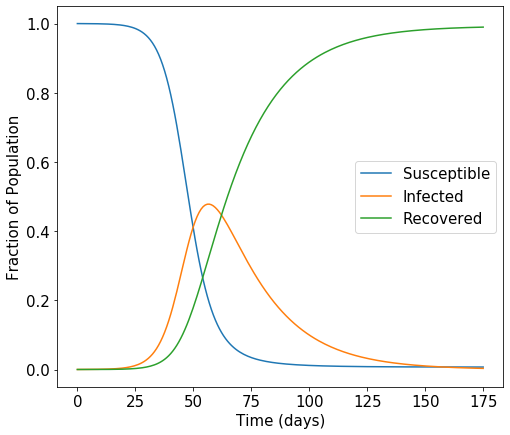

In [18]:
sol = scipy.integrate.odeint(SIR_model, y0, t, args=(infect_rate, recov_rate, N))

plt.figure(figsize=(8, 7))

plt.rcParams.update({'font.size': 15})

plt.plot(t, sol[:, 0] / N, label='Susceptible')
plt.plot(t, sol[:, 1] / N, label='Infected')
plt.plot(t, sol[:, 2] / N, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Fraction of Population')

plt.legend(loc='center right')

plt.savefig('SIR_model.png')

In [ ]:
# filepaths
fp_in = "slides/*.png"
fp_out = "slides/disease_spread.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=300, loop=0)